### Importing libraries

In [1364]:
!pip install git+https://github.com/gbolmier/funk-svd 

  Cloning https://github.com/gbolmier/funk-svd to /private/var/folders/dx/3vxbz5s15v9d6d9kx6cr_0ph0000gn/T/pip-req-build-d_84ggfj
  Running command git clone --filter=blob:none --quiet https://github.com/gbolmier/funk-svd /private/var/folders/dx/3vxbz5s15v9d6d9kx6cr_0ph0000gn/T/pip-req-build-d_84ggfj
  Resolved https://github.com/gbolmier/funk-svd to commit fecc38ea1c2859ef6a6d9af0b7f953e1b693764e
  Preparing metadata (setup.py) ... done


In [1660]:
import numpy as np
import random
import pandas as pd
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import textwrap as twp
from funk_svd import SVD 
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import time

### Importing Data

In [1366]:
column_names = ['u_id', 'i_id', 'rating', 'timestamp']
ml100k = pd.read_csv('u.data', sep='\t', names=column_names)
ml100k.drop(ml100k[(ml100k['u_id'] == 0)].index, inplace=True)
ml100k.head()

,u_id,i_id,rating,timestamp
3,196,242,3,881250949
4,186,302,3,891717742
5,22,377,1,878887116
6,244,51,2,880606923
7,166,346,1,886397596


In [1367]:
column_names = ['u_id','Age','Gender','Occupation','zip_code']
user_data = pd.read_csv('u.user', sep = '|', names = column_names) 
user_data 

,u_id,Age,Gender,Occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


### Splitting data into train, valid and test set

In [1368]:
X = ml100k.drop(['rating'], axis = 1)

In [1369]:
y = ml100k['rating']

In [1370]:
# train_test_split
from sklearn.model_selection import train_test_split
train_ratio = 0.75
validation_ratio = 0.15 
test_ratio = 0.10

# train set is 90% of the entire dataset
    # Out of train set, 15% is validation set
    # Out of train set, 75% is used for actual training
# test set is 10% of the entire dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_ratio)
X_train ,X_val,y_train, y_val = train_test_split(X_train, y_train, test_size = validation_ratio) 


In [1371]:
# concatinating X_train and y_train for training on SVD
X_train_svd = pd.concat([X_train, y_train], axis = 1)
X_train_svd.head()

,u_id,i_id,timestamp,rating
77566,442,1170,883388909,4
62093,385,1014,879450441,2
71888,535,566,879618338,3
74693,868,227,877110060,1
62764,536,179,882359625,2


In [1372]:
# concatinating X_val and Y_val for validating
X_val_svd = pd.concat([X_val, y_val], axis = 1) 
X_val_svd.head() 

,u_id,i_id,timestamp,rating
17327,293,280,888905198,2
91296,261,596,890456142,2
37468,190,544,891033806,4
329,200,304,876041644,5
2013,177,56,880130618,5


### Model One (M1) - Entirely unpruned dataset

#### Funk SVD - M1

In [1373]:
def Svd(X_train, X_val, X_test, y_test): 
 
  svd = SVD(lr = 0.001, reg=0.005, n_epochs=150, n_factors=15, 
          early_stopping = True, shuffle = False, min_rating=1, max_rating=5)
  start = time.time()
  svd.fit(X = X_train, X_val = X_val)
  svd_Ttime = round(time.time() - start,4)
  start = time.time()
  pred = svd.predict(X_test)
  svd_Ptime = round(time.time() - start,4)
  mae = round(mean_absolute_error(y_test, pred),4)
  rmse = round(mean_squared_error(y_test, pred, squared = False),4)
  print(f'Mae is {mae} and Rmse is {rmse}')
  print(f'Training time is {svd_Ttime} and Prediction time is {svd_Ptime}')
  return mae, rmse, svd_Ttime, svd_Ptime
svd_mae_m1, svd_rmse_m1, tt_svd_m1, pt_svd_m1 = Svd(X_train_svd, X_val_svd, X_test, y_test) 


Preprocessing data...

Preprocessing data...

Epoch 1/150  | val_loss: 1.19 - val_rmse: 1.09 - val_mae: 0.91 - took 0.0 sec
Epoch 2/150  | val_loss: 1.13 - val_rmse: 1.06 - val_mae: 0.88 - took 0.0 sec
Epoch 3/150  | val_loss: 1.08 - val_rmse: 1.04 - val_mae: 0.86 - took 0.0 sec
Epoch 4/150  | val_loss: 1.06 - val_rmse: 1.03 - val_mae: 0.84 - took 0.0 sec
Epoch 5/150  | val_loss: 1.03 - val_rmse: 1.02 - val_mae: 0.83 - took 0.0 sec
Epoch 6/150  | val_loss: 1.02 - val_rmse: 1.01 - val_mae: 0.82 - took 0.0 sec
Epoch 7/150  | val_loss: 1.01 - val_rmse: 1.00 - val_mae: 0.81 - took 0.0 sec
Epoch 8/150  | val_loss: 0.99 - val_rmse: 1.00 - val_mae: 0.80 - took 0.0 sec
Epoch 9/150  | val_loss: 0.99 - val_rmse: 0.99 - val_mae: 0.80 - took 0.0 sec
Epoch 10/150 | val_loss: 0.98 - val_rmse: 0.99 - val_mae: 0.79 - took 0.0 sec
Epoch 11/150 | val_loss: 0.97 - val_rmse: 0.99 - val_mae: 0.79 - took 0.0 sec
Epoch 12/150 | val_loss: 0.97 - val_rmse: 0.98 - val_mae: 0.79 - took 0.0 sec
Epoch 13/150 | val

#### Xgboost - M1

In [1374]:
def XgBoost(X_train, y_train, X_test, y_test):
    xb = XGBRegressor()
    start = time.time()
    xb.fit(X_train, y_train)
    xb_Ttime = round(time.time() - start,4)
    start = time.time()
    xb_pred = xb.predict(X_test)
    xb_Ptime = round(time.time() - start,4) 
    xb_mae =  round(mean_absolute_error(y_test, xb_pred),4)
    xb_rmse =  round(mean_squared_error(y_test, xb_pred, squared = False),4)
    print(f'The mae is {xb_mae} and rmse is {xb_rmse}')
    print(f'Training time is {xb_Ttime} and Prediction time is {xb_Ptime}')
    return xb_mae, xb_rmse, xb_Ttime, xb_Ptime
xb_mae_m1, xb_rmse_m1, tt_xb_m1, pt_xb_m1 = XgBoost(X_train, y_train, X_test, y_test)

The mae is 0.7595 and rmse is 0.9535
Training time is 2.2447 and Prediction time is 0.0074


#### Random Forest Regressor - M1

In [1375]:
def Random_Forest(X_train, y_train, X_test, y_test):
    rf = RandomForestRegressor(n_estimators = 200)
    start = time.time() 
    rf.fit(X_train, y_train)
    rf_Ttime = round(time.time() - start,4)
    start = time.time()
    rf_pred = rf.predict(X_test)
    rf_Ptime = round(time.time() - start,4) 
    rf_mae =  round(mean_absolute_error(y_test, rf_pred),4 )
    rf_rmse =  round(mean_squared_error(y_test, rf_pred),4)
    print(f'The mae is {rf_mae} and rmse is {rf_rmse}')
    print(f'Training time is {rf_Ttime} and Prediction time is {rf_Ptime}')
    return rf_mae, rf_rmse, rf_Ttime, rf_Ptime
rf_mae_m1, rf_rmse_m1, tt_rf_m1, pt_rf_m1 = Random_Forest(X_train, y_train, X_test, y_test) 

The mae is 0.8095 and rmse is 1.0379
Training time is 42.5655 and Prediction time is 0.8843


### Model Two (M2) - Pruning on the basis of movie ratings

#### Pruning all the movies whose ratings are less than 2 

In [1376]:
# for training set
def ratings_less_than_n(X_set, y_set, n):
    X_set_for_pruning = pd.concat([X_set, y_set], axis = 1) 
    X_set_pruned_ratings = X_set_for_pruning[X_set_for_pruning['rating'] > n]
    y_set_pruned_ratings = X_set_pruned_ratings['rating'] 
    return X_set_pruned_ratings, y_set_pruned_ratings 
X_train_pruned_ratings,y_train_pruned_ratings = ratings_less_than_n(X_train, y_train, 2) 

In [1377]:
# for validation set
X_val_pruned_ratings,y_val_pruned_ratings = ratings_less_than_n(X_val, y_val, 2) 

#### FunkSVD - M2

In [1378]:
svd_mae_m2, svd_rmse_m2, tt_svd_m2, pt_svd_m2 = Svd(X_train_pruned_ratings, X_val_pruned_ratings, X_test, y_test)  

Preprocessing data...

Preprocessing data...

Epoch 1/150  | val_loss: 0.56 - val_rmse: 0.75 - val_mae: 0.61 - took 0.0 sec
Epoch 2/150  | val_loss: 0.55 - val_rmse: 0.74 - val_mae: 0.60 - took 0.0 sec
Epoch 3/150  | val_loss: 0.53 - val_rmse: 0.73 - val_mae: 0.60 - took 0.0 sec
Epoch 4/150  | val_loss: 0.52 - val_rmse: 0.72 - val_mae: 0.59 - took 0.0 sec
Epoch 5/150  | val_loss: 0.51 - val_rmse: 0.72 - val_mae: 0.59 - took 0.0 sec
Epoch 6/150  | val_loss: 0.51 - val_rmse: 0.71 - val_mae: 0.59 - took 0.0 sec
Epoch 7/150  | val_loss: 0.50 - val_rmse: 0.71 - val_mae: 0.59 - took 0.0 sec
Epoch 8/150  | val_loss: 0.50 - val_rmse: 0.70 - val_mae: 0.59 - took 0.0 sec
Epoch 9/150  | val_loss: 0.49 - val_rmse: 0.70 - val_mae: 0.58 - took 0.0 sec
Epoch 10/150 | val_loss: 0.49 - val_rmse: 0.70 - val_mae: 0.58 - took 0.0 sec
Epoch 11/150 | val_loss: 0.49 - val_rmse: 0.70 - val_mae: 0.58 - took 0.0 sec
Epoch 12/150 | val_loss: 0.49 - val_rmse: 0.70 - val_mae: 0.58 - took 0.0 sec
Epoch 13/150 | val

In [1379]:
X_train_pruned_ratings.drop(['rating'], axis = 1, inplace = True)

#### XgBoost - M2

In [1380]:
xb_mae_m2, xb_rmse_m2, tt_xb_m2, pt_xb_m2 = XgBoost(X_train_pruned_ratings, y_train_pruned_ratings, X_test, y_test) 

The mae is 0.8253 and rmse is 1.0851
Training time is 2.1446 and Prediction time is 0.0076


#### Random Forest Regressor - M2

In [1381]:
rf_mae_m2, rf_rmse_m2, tt_rf_m2, pt_rf_m2 = Random_Forest(X_train_pruned_ratings, y_train_pruned_ratings, X_test, y_test) 

The mae is 0.8577 and rmse is 1.2416
Training time is 34.7856 and Prediction time is 0.6689


### Random Pruning - M2

In [1382]:
def difference(X_before, X_after):
  diff = X_before.shape[0] - X_after.shape[0] 
  return diff
n_m2 = difference(X_train, X_train_pruned_ratings)
n_m2

13343

In [1383]:
# n = number of rows to be pruned 
def random_pruning(X_set, y_set, n,s):
    X_set2 = pd.concat([X_set, y_set], axis = 1) 
    np.random.seed(s) 
    drop_indices = np.random.choice(X_set2.index, n, replace=False)
    X_train_randomly_pruned = X_set2.drop(drop_indices)
    y_train_randomly_pruned = X_train_randomly_pruned['rating']
    return X_train_randomly_pruned, y_train_randomly_pruned
X_train_randomly_pruned2, y_train_randomly_pruned2 = random_pruning(X_train, y_train, n_m2,0)

In [1384]:
def difference(X_before, X_after):
  diff = X_before.shape[0] - X_after.shape[0] 
  return diff
n_v_m2 = difference(X_val, X_val_pruned_ratings)
n_v_m2

2409

In [1385]:
# for validation set - we take n_v_m2 as we have pruned in above algorithm 
X_val_randomly_pruned2, y_val_randomly_pruned2 = random_pruning(X_val, y_val, n_v_m2,0) 

In [1386]:
X_val_randomly_pruned2.shape

(11091, 4)

In [1387]:
# SVD
svd_mae_rp_m2, svd_rmse_rp_m2, tt_svd_rp_m2, pt_svd_rp_m2 = Svd(X_train_randomly_pruned2, X_val_randomly_pruned2, X_test, y_test)   

Preprocessing data...

Preprocessing data...

Epoch 1/150  | val_loss: 1.20 - val_rmse: 1.10 - val_mae: 0.92 - took 0.0 sec
Epoch 2/150  | val_loss: 1.14 - val_rmse: 1.07 - val_mae: 0.89 - took 0.0 sec
Epoch 3/150  | val_loss: 1.10 - val_rmse: 1.05 - val_mae: 0.87 - took 0.0 sec
Epoch 4/150  | val_loss: 1.07 - val_rmse: 1.04 - val_mae: 0.85 - took 0.0 sec
Epoch 5/150  | val_loss: 1.05 - val_rmse: 1.03 - val_mae: 0.84 - took 0.0 sec
Epoch 6/150  | val_loss: 1.04 - val_rmse: 1.02 - val_mae: 0.83 - took 0.0 sec
Epoch 7/150  | val_loss: 1.02 - val_rmse: 1.01 - val_mae: 0.82 - took 0.0 sec
Epoch 8/150  | val_loss: 1.01 - val_rmse: 1.00 - val_mae: 0.81 - took 0.0 sec
Epoch 9/150  | val_loss: 1.00 - val_rmse: 1.00 - val_mae: 0.81 - took 0.0 sec
Epoch 10/150 | val_loss: 0.99 - val_rmse: 1.00 - val_mae: 0.80 - took 0.0 sec
Epoch 11/150 | val_loss: 0.99 - val_rmse: 0.99 - val_mae: 0.80 - took 0.0 sec
Epoch 12/150 | val_loss: 0.98 - val_rmse: 0.99 - val_mae: 0.79 - took 0.0 sec
Epoch 13/150 | val

In [1388]:
X_train_randomly_pruned2.drop(['rating'], axis = 1, inplace = True)

In [1389]:
# XgBoost
xb_mae_rp_m2, xb_rmse_rp_m2, tt_xb_rp_m2, pt_xb_rp_m2 = XgBoost(X_train_randomly_pruned2, y_train_randomly_pruned2, X_test, y_test)  

The mae is 0.7615 and rmse is 0.9557
Training time is 2.2407 and Prediction time is 0.0089


In [1390]:
# Random Forest Regressor
rf_mae_rp_m2, rf_rmse_rp_m2, tt_rf_rp_m2, pt_rf_rp_m2 = Random_Forest(X_train_randomly_pruned2, y_train_randomly_pruned2, X_test, y_test)  

The mae is 0.8107 and rmse is 1.0389
Training time is 34.7104 and Prediction time is 0.7064


#### Pruning all the movies whose ratings are less than 3

In [1391]:
# calling the function for pruning 
# training data 
X_train_pruned_ratings_3, y_train_pruned_ratings_3 = ratings_less_than_n(X_train, y_train, 3) 

In [1392]:
# validation data 
X_val_pruned_ratings_3, y_val_pruned_ratings_3 = ratings_less_than_n(X_val, y_val, 3)

In [1393]:
# SVD
svd_mae_m2_3, svd_rmse_m2_3, tt_svd_m2_3, pt_svd_m2_3 = Svd(X_train_pruned_ratings_3, X_val_pruned_ratings_3, X_test, y_test) 

Preprocessing data...

Preprocessing data...

Epoch 1/150  | val_loss: 0.23 - val_rmse: 0.48 - val_mae: 0.47 - took 0.0 sec
Epoch 2/150  | val_loss: 0.23 - val_rmse: 0.48 - val_mae: 0.46 - took 0.0 sec
Epoch 3/150  | val_loss: 0.23 - val_rmse: 0.48 - val_mae: 0.46 - took 0.0 sec
Epoch 4/150  | val_loss: 0.22 - val_rmse: 0.47 - val_mae: 0.46 - took 0.0 sec
Epoch 5/150  | val_loss: 0.22 - val_rmse: 0.47 - val_mae: 0.45 - took 0.0 sec
Epoch 6/150  | val_loss: 0.22 - val_rmse: 0.47 - val_mae: 0.45 - took 0.0 sec
Epoch 7/150  | val_loss: 0.22 - val_rmse: 0.47 - val_mae: 0.45 - took 0.0 sec
Epoch 8/150  | val_loss: 0.22 - val_rmse: 0.46 - val_mae: 0.44 - took 0.0 sec
Epoch 9/150  | val_loss: 0.21 - val_rmse: 0.46 - val_mae: 0.44 - took 0.0 sec
Epoch 10/150 | val_loss: 0.21 - val_rmse: 0.46 - val_mae: 0.44 - took 0.0 sec
Epoch 11/150 | val_loss: 0.21 - val_rmse: 0.46 - val_mae: 0.44 - took 0.0 sec

Training took 0 sec
Mae is 1.0695 and Rmse is 1.3761
Training time is 0.0536 and Prediction tim

In [1394]:
X_train_pruned_ratings_3.drop(['rating'], axis = 1, inplace = True) 

In [1395]:
# XgBoost
xb_mae_m2_3, xb_rmse_m2_3,tt_xb_m2_3, pt_xb_m2_3 = XgBoost(X_train_pruned_ratings_3, y_train_pruned_ratings_3, X_test, y_test) 

The mae is 1.0374 and rmse is 1.3486
Training time is 1.5381 and Prediction time is 0.0085


In [1396]:
# Random Forest Regressor
rf_mae_m2_3, rf_rmse_m2_3,tt_rf_m2_3, pt_rf_m2_3 = Random_Forest(X_train_pruned_ratings_3, y_train_pruned_ratings_3, X_test, y_test) 

The mae is 1.0486 and rmse is 1.8712
Training time is 23.0571 and Prediction time is 0.5284


### Model Three (M3) - Pruning on the basis of user ratings

#### Pruning users who have rated less than 30 movies

In [1397]:
counts = X_train['u_id'].value_counts() 

def total_rating_less_than_n(X_set, y_set, counts, n):
    X_set_for_pruning_n = pd.concat([X_set, y_set], axis = 1) 
    set_pruned_n = X_set_for_pruning_n.loc[X_set_for_pruning_n['u_id'].isin(counts.index[counts > n])]
    y_set_pruned_n = set_pruned_n['rating']
    return set_pruned_n, y_set_pruned_n
train_pruned_30, y_train_pruned_30 = total_rating_less_than_n(X_train, y_train,counts, n=30)

In [1398]:
val_pruned_30, y_val_pruned_30 = total_rating_less_than_n(X_val, y_val,counts, 30)

In [1399]:
train_pruned_30.shape

(70228, 4)

In [1400]:
val_pruned_30.shape

(12326, 4)

#### FunkSVD - M3

In [1401]:
#SVD
svd_mae_m3, svd_rmse_m3, tt_svd_m3, pt_svd_m3 = Svd(train_pruned_30, val_pruned_30, X_test, y_test) 

Preprocessing data...

Preprocessing data...

Epoch 1/150  | val_loss: 1.18 - val_rmse: 1.09 - val_mae: 0.91 - took 0.0 sec
Epoch 2/150  | val_loss: 1.12 - val_rmse: 1.06 - val_mae: 0.88 - took 0.0 sec
Epoch 3/150  | val_loss: 1.07 - val_rmse: 1.04 - val_mae: 0.85 - took 0.0 sec
Epoch 4/150  | val_loss: 1.04 - val_rmse: 1.02 - val_mae: 0.83 - took 0.0 sec
Epoch 5/150  | val_loss: 1.02 - val_rmse: 1.01 - val_mae: 0.82 - took 0.0 sec
Epoch 6/150  | val_loss: 1.01 - val_rmse: 1.00 - val_mae: 0.81 - took 0.0 sec
Epoch 7/150  | val_loss: 0.99 - val_rmse: 1.00 - val_mae: 0.80 - took 0.0 sec
Epoch 8/150  | val_loss: 0.98 - val_rmse: 0.99 - val_mae: 0.79 - took 0.0 sec
Epoch 9/150  | val_loss: 0.97 - val_rmse: 0.99 - val_mae: 0.79 - took 0.0 sec
Epoch 10/150 | val_loss: 0.97 - val_rmse: 0.98 - val_mae: 0.79 - took 0.0 sec
Epoch 11/150 | val_loss: 0.96 - val_rmse: 0.98 - val_mae: 0.78 - took 0.0 sec
Epoch 12/150 | val_loss: 0.95 - val_rmse: 0.98 - val_mae: 0.78 - took 0.0 sec
Epoch 13/150 | val

In [1402]:
train_pruned_30.drop(['rating'], axis = 1, inplace = True)

#### XgBoost - M3

In [1403]:
#XgBoost
xb_mae_m3, xb_rmse_m3, tt_xb_m3, pt_xb_m3 = XgBoost(train_pruned_30, y_train_pruned_30, X_test, y_test)

The mae is 0.7615 and rmse is 0.9589
Training time is 2.2653 and Prediction time is 0.0074


#### Random Forest Rwgressor - M3

In [1404]:
#RandomForestRegressor
rf_mae_m3, rf_rmse_m3, tt_rf_m3, pt_rf_m3 = Random_Forest(train_pruned_30, y_train_pruned_30, X_test, y_test)

The mae is 0.809 and rmse is 1.0389
Training time is 38.6152 and Prediction time is 0.8135


### Random Pruning - M3

In [1405]:
n_m3 = difference(X_train, train_pruned_30) 
n_m3

6272

In [1406]:
X_train_randomly_pruned3, y_train_randomly_pruned3 = random_pruning(X_train, y_train, n_m3,0) 

In [1407]:
X_train_randomly_pruned3.shape

(70228, 4)

In [1408]:
n_v_m3 = difference(X_val, val_pruned_30)

In [1409]:
X_val_randomly_pruned3, y_val_randomly_pruned3 = random_pruning(X_val, y_val, n_v_m3,0)

In [1410]:
X_val_randomly_pruned3.shape

(12326, 4)

In [1411]:
# SVD
svd_mae_rp_m3, svd_rmse_rp_m3,tt_svd_rp_m3, pt_svd_rp_m3 = Svd(X_train_randomly_pruned3, X_val_randomly_pruned3, X_test, y_test) 

Preprocessing data...

Preprocessing data...

Epoch 1/150  | val_loss: 1.19 - val_rmse: 1.09 - val_mae: 0.92 - took 0.0 sec
Epoch 2/150  | val_loss: 1.13 - val_rmse: 1.06 - val_mae: 0.89 - took 0.0 sec
Epoch 3/150  | val_loss: 1.09 - val_rmse: 1.05 - val_mae: 0.86 - took 0.0 sec
Epoch 4/150  | val_loss: 1.06 - val_rmse: 1.03 - val_mae: 0.84 - took 0.0 sec
Epoch 5/150  | val_loss: 1.04 - val_rmse: 1.02 - val_mae: 0.83 - took 0.0 sec
Epoch 6/150  | val_loss: 1.03 - val_rmse: 1.01 - val_mae: 0.82 - took 0.0 sec
Epoch 7/150  | val_loss: 1.01 - val_rmse: 1.01 - val_mae: 0.81 - took 0.0 sec
Epoch 8/150  | val_loss: 1.00 - val_rmse: 1.00 - val_mae: 0.81 - took 0.0 sec
Epoch 9/150  | val_loss: 0.99 - val_rmse: 1.00 - val_mae: 0.80 - took 0.0 sec
Epoch 10/150 | val_loss: 0.98 - val_rmse: 0.99 - val_mae: 0.80 - took 0.0 sec
Epoch 11/150 | val_loss: 0.98 - val_rmse: 0.99 - val_mae: 0.79 - took 0.0 sec
Epoch 12/150 | val_loss: 0.97 - val_rmse: 0.99 - val_mae: 0.79 - took 0.0 sec
Epoch 13/150 | val

In [1412]:
X_train_randomly_pruned3.drop(['rating'], axis = 1, inplace = True)

In [1413]:
# XgBoost
xb_mae_rp_m3, xb_rmse_rp_m3, tt_xb_rp_m3, pt_xb_rp_m3 = XgBoost(X_train_randomly_pruned3, y_train_randomly_pruned3, X_test, y_test) 

The mae is 0.761 and rmse is 0.956
Training time is 2.5601 and Prediction time is 0.0074


In [1414]:
# Random Forest Regressor
rf_mae_rp_m3, rf_rmse_rp_m3, tt_rf_rp_m3, pt_xb_rp_m3 = Random_Forest(X_train_randomly_pruned3, y_train_randomly_pruned3, X_test, y_test) 

The mae is 0.8123 and rmse is 1.042
Training time is 39.3672 and Prediction time is 0.7549


#### Pruning users who have rated less than 40 movies

In [1608]:
train_pruned_40, y_train_pruned_40 = total_rating_less_than_n(X_train, y_train,counts, 40)

In [1609]:
val_pruned_40, y_val_pruned_40 = total_rating_less_than_n(X_val, y_val,counts, 40)

In [1610]:
# SVD
svd_mae_m3_40, svd_rmse_m3_40, tt_svd_m3_40, pt_svd_m3_40 = Svd(train_pruned_40, val_pruned_40, X_test, y_test) 

Preprocessing data...

Preprocessing data...

Epoch 1/150  | val_loss: 1.18 - val_rmse: 1.09 - val_mae: 0.91 - took 0.0 sec
Epoch 2/150  | val_loss: 1.12 - val_rmse: 1.06 - val_mae: 0.88 - took 0.0 sec
Epoch 3/150  | val_loss: 1.07 - val_rmse: 1.04 - val_mae: 0.85 - took 0.0 sec
Epoch 4/150  | val_loss: 1.04 - val_rmse: 1.02 - val_mae: 0.83 - took 0.0 sec
Epoch 5/150  | val_loss: 1.02 - val_rmse: 1.01 - val_mae: 0.82 - took 0.0 sec
Epoch 6/150  | val_loss: 1.00 - val_rmse: 1.00 - val_mae: 0.81 - took 0.0 sec
Epoch 7/150  | val_loss: 0.99 - val_rmse: 0.99 - val_mae: 0.80 - took 0.0 sec
Epoch 8/150  | val_loss: 0.98 - val_rmse: 0.99 - val_mae: 0.79 - took 0.0 sec
Epoch 9/150  | val_loss: 0.97 - val_rmse: 0.99 - val_mae: 0.79 - took 0.0 sec
Epoch 10/150 | val_loss: 0.96 - val_rmse: 0.98 - val_mae: 0.78 - took 0.0 sec
Epoch 11/150 | val_loss: 0.96 - val_rmse: 0.98 - val_mae: 0.78 - took 0.0 sec
Epoch 12/150 | val_loss: 0.95 - val_rmse: 0.98 - val_mae: 0.78 - took 0.0 sec
Epoch 13/150 | val

In [1418]:
train_pruned_40 = train_pruned_40.drop(['rating'], axis = 1) 

In [1419]:
# XgBoost
xb_mae_m3_40, xb_rmse_m3_40,tt_xb_m3_40, pt_xb_m3_40  = XgBoost(train_pruned_40, y_train_pruned_40, X_test, y_test)

The mae is 0.7663 and rmse is 0.9617
Training time is 2.1349 and Prediction time is 0.0076


In [1420]:
# Random Forest Regressor
rf_mae_m3_40, rf_rmse_m3_40, tt_rf_m3_40, pt_rf_m3_40 = Random_Forest(train_pruned_40, y_train_pruned_40, X_test, y_test)

The mae is 0.8103 and rmse is 1.0385
Training time is 36.4453 and Prediction time is 0.784


### Model Four (M4) - Pruning data on the basis of timestamp
#### The MovieLens100k dataset consists of data between 1997 and 1998.

#### Pruning data for initial 2 months

In [1421]:
from datetime import datetime 
Timestamp = X_train['timestamp'].sort_values(ascending = True)  
Timestamp[:25000] 

217      874724710
83968    874724727
21399    874724781
82658    874724843
1769     874724882
           ...    
6098     879968598
17959    879968663
15929    879968663
78567    879968718
4281     879968742
Name: timestamp, Length: 25000, dtype: int64

In [1422]:
ts = int("874724727") 
print(datetime.utcfromtimestamp(ts).strftime('%m-%d-%Y')) 

09-20-1997


In [1423]:
ts = int("879969064") 
print(datetime.utcfromtimestamp(ts).strftime('%m-%d-%Y')) 

11-19-1997


In [1424]:
timestamp1 = 879969064
def timestamp_n(X_train_timestamp, y_train, timestamp): 
  # concating X_train and y_train 
  X_train_timestamp_for_pruning = pd.concat([X_train_timestamp, y_train], axis = 1)
  # pruning train data 
  X_train_timestamp_pruned = X_train_timestamp_for_pruning[X_train_timestamp_for_pruning['timestamp'] > timestamp] 
  y_train_timestamp_pruned = X_train_timestamp_pruned['rating']
  X_train_timestamp_pruned.columns = ['u_id','i_id','timestamp','rating'] 
  return X_train_timestamp_pruned, y_train_timestamp_pruned
X_train_timestamp_pruned, y_train_timestamp_pruned = timestamp_n(X_train, y_train, timestamp1)

In [1425]:
# for validation set 
X_val_timestamp_pruned, y_val_timestamp_pruned = timestamp_n(X_val, y_val, timestamp1) 

#### FunkSVD - M4

In [1426]:
svd_mae_m4, svd_rmse_m4, tt_svd_m4, pt_svd_m4 = Svd(X_train_timestamp_pruned, X_val_timestamp_pruned, X_test, y_test) 

Preprocessing data...

Preprocessing data...

Epoch 1/150  | val_loss: 1.20 - val_rmse: 1.10 - val_mae: 0.92 - took 0.0 sec
Epoch 2/150  | val_loss: 1.15 - val_rmse: 1.07 - val_mae: 0.89 - took 0.0 sec
Epoch 3/150  | val_loss: 1.11 - val_rmse: 1.05 - val_mae: 0.87 - took 0.0 sec
Epoch 4/150  | val_loss: 1.08 - val_rmse: 1.04 - val_mae: 0.85 - took 0.0 sec
Epoch 5/150  | val_loss: 1.06 - val_rmse: 1.03 - val_mae: 0.84 - took 0.0 sec
Epoch 6/150  | val_loss: 1.05 - val_rmse: 1.02 - val_mae: 0.83 - took 0.0 sec
Epoch 7/150  | val_loss: 1.03 - val_rmse: 1.02 - val_mae: 0.82 - took 0.0 sec
Epoch 8/150  | val_loss: 1.02 - val_rmse: 1.01 - val_mae: 0.82 - took 0.0 sec
Epoch 9/150  | val_loss: 1.01 - val_rmse: 1.01 - val_mae: 0.81 - took 0.0 sec
Epoch 10/150 | val_loss: 1.01 - val_rmse: 1.00 - val_mae: 0.81 - took 0.0 sec
Epoch 11/150 | val_loss: 1.00 - val_rmse: 1.00 - val_mae: 0.80 - took 0.0 sec
Epoch 12/150 | val_loss: 0.99 - val_rmse: 1.00 - val_mae: 0.80 - took 0.0 sec
Epoch 13/150 | val

In [1427]:
X_train_timestamp_pruned.drop(['rating'],axis = 1, inplace = True)

#### XgBoost - M4

In [1428]:
xb = XGBRegressor()
start = time.time() 
xb.fit(X_train_timestamp_pruned, y_train_timestamp_pruned)
tt_xb_m4 = round(time.time() - start, 4)
start = time.time()
xb_pred = xb.predict(X_test) 
pt_xb_m4 = round(time.time() - start, 4)
xb_mae_m4 =  round(mean_absolute_error(y_test, xb_pred),4)
xb_rmse_m4 =  round(mean_squared_error(y_test, xb_pred, squared = False),4)
print(f'Mae is {xb_mae_m4} and Rmse is {xb_rmse_m4}') 


Mae is 0.8046 and Rmse is 1.0069


#### Random Forest Regressor - M4

In [1429]:
rf_mae_m4, rf_rmse_m4, tt_rf_m4, pt_rf_m4  = Random_Forest(X_train_timestamp_pruned, y_train_timestamp_pruned, X_test, y_test)

The mae is 0.8386 and rmse is 1.0989
Training time is 27.7068 and Prediction time is 0.6076


### Random Pruning - M4

In [1430]:
n_m4 = difference(X_train, X_train_timestamp_pruned) 
n_m4

25032

In [1431]:
X_train_randomly_pruned4, y_train_randomly_pruned4 = random_pruning(X_train, y_train,n_m4,0) 

In [1432]:
X_train_randomly_pruned4.shape

(51468, 4)

In [1433]:
n_v_m4 = difference(X_val, X_val_timestamp_pruned)

In [1434]:
X_val_randomly_pruned4, y_val_randomly_pruned4 = random_pruning(X_val, y_val, n_v_m4,0)

In [1435]:
X_val_randomly_pruned4.shape

(9053, 4)

In [1436]:
# SVD
svd_mae_rp_m4, svd_rmse_rp_m4,tt_svd_rp_m4, pt_svd_rp_m4 = Svd(X_train_randomly_pruned4, X_val_randomly_pruned4, X_test, y_test) 

Preprocessing data...

Preprocessing data...

Epoch 1/150  | val_loss: 1.21 - val_rmse: 1.10 - val_mae: 0.92 - took 0.0 sec
Epoch 2/150  | val_loss: 1.16 - val_rmse: 1.08 - val_mae: 0.90 - took 0.0 sec
Epoch 3/150  | val_loss: 1.12 - val_rmse: 1.06 - val_mae: 0.88 - took 0.0 sec
Epoch 4/150  | val_loss: 1.09 - val_rmse: 1.05 - val_mae: 0.86 - took 0.0 sec
Epoch 5/150  | val_loss: 1.07 - val_rmse: 1.03 - val_mae: 0.85 - took 0.0 sec
Epoch 6/150  | val_loss: 1.05 - val_rmse: 1.03 - val_mae: 0.84 - took 0.0 sec
Epoch 7/150  | val_loss: 1.04 - val_rmse: 1.02 - val_mae: 0.83 - took 0.0 sec
Epoch 8/150  | val_loss: 1.03 - val_rmse: 1.01 - val_mae: 0.82 - took 0.0 sec
Epoch 9/150  | val_loss: 1.02 - val_rmse: 1.01 - val_mae: 0.81 - took 0.0 sec
Epoch 10/150 | val_loss: 1.01 - val_rmse: 1.00 - val_mae: 0.81 - took 0.0 sec
Epoch 11/150 | val_loss: 1.00 - val_rmse: 1.00 - val_mae: 0.80 - took 0.0 sec
Epoch 12/150 | val_loss: 1.00 - val_rmse: 1.00 - val_mae: 0.80 - took 0.0 sec
Epoch 13/150 | val

In [1437]:
X_train_randomly_pruned4.drop(['rating'], axis = 1, inplace = True)

In [1438]:
# XgBoost
xb_mae_rp_m4, xb_rmse_rp_m4, tt_xb_rp_m4, pt_xb_rp_m4 = XgBoost(X_train_randomly_pruned4, y_train_randomly_pruned4, X_test, y_test) 

The mae is 0.7648 and rmse is 0.9598
Training time is 1.8318 and Prediction time is 0.008


In [1439]:
# Random Forest Regressor
rf_mae_rp_m4, rf_rmse_rp_m4, tt_rf_rp_m4, pt_rf_rp_m4 = Random_Forest(X_train_randomly_pruned4, y_train_randomly_pruned4, X_test, y_test) 

The mae is 0.8172 and rmse is 1.0547
Training time is 28.5256 and Prediction time is 0.6629


#### Puning data for initial 3 months


In [1440]:
from datetime import datetime 
Timestamp = X_train['timestamp'].sort_values(ascending = True)  
Timestamp[:38000] 

217      874724710
83968    874724727
21399    874724781
82658    874724843
1769     874724882
           ...    
18466    882813312
57957    882813315
68174    882813316
89827    882813364
70198    882813364
Name: timestamp, Length: 38000, dtype: int64

In [1441]:
ts = int("874724727") 
print(datetime.utcfromtimestamp(ts).strftime('%m-%d-%Y')) 

09-20-1997


In [1442]:
ts = int("882813143") 
print(datetime.utcfromtimestamp(ts).strftime('%m-%d-%Y')) 

12-22-1997


In [1443]:
# for training data
timestamp2 = 882813143 
X_train_timestamp_pruned_3, y_train_timestamp_pruned_3 = timestamp_n(X_train, y_train, timestamp2)

In [1444]:
# for validation data
X_val_timestamp_pruned_3, y_val_timestamp_pruned_3 = timestamp_n(X_val, y_val, timestamp2)

In [1445]:
# SVD 
svd_mae_m4_t2, svd_rmse_m4_t2, tt_svd_m4_t2, pt_svd_m4_t2 = Svd(X_train_timestamp_pruned_3, X_val_timestamp_pruned_3, X_test, y_test) 

Preprocessing data...

Preprocessing data...

Epoch 1/150  | val_loss: 1.23 - val_rmse: 1.11 - val_mae: 0.93 - took 0.0 sec
Epoch 2/150  | val_loss: 1.18 - val_rmse: 1.08 - val_mae: 0.91 - took 0.0 sec
Epoch 3/150  | val_loss: 1.14 - val_rmse: 1.07 - val_mae: 0.89 - took 0.0 sec
Epoch 4/150  | val_loss: 1.11 - val_rmse: 1.05 - val_mae: 0.87 - took 0.0 sec
Epoch 5/150  | val_loss: 1.09 - val_rmse: 1.04 - val_mae: 0.86 - took 0.0 sec
Epoch 6/150  | val_loss: 1.07 - val_rmse: 1.04 - val_mae: 0.84 - took 0.0 sec
Epoch 7/150  | val_loss: 1.06 - val_rmse: 1.03 - val_mae: 0.84 - took 0.0 sec
Epoch 8/150  | val_loss: 1.05 - val_rmse: 1.02 - val_mae: 0.83 - took 0.0 sec
Epoch 9/150  | val_loss: 1.04 - val_rmse: 1.02 - val_mae: 0.82 - took 0.0 sec
Epoch 10/150 | val_loss: 1.03 - val_rmse: 1.01 - val_mae: 0.82 - took 0.0 sec
Epoch 11/150 | val_loss: 1.02 - val_rmse: 1.01 - val_mae: 0.82 - took 0.0 sec
Epoch 12/150 | val_loss: 1.01 - val_rmse: 1.01 - val_mae: 0.81 - took 0.0 sec
Epoch 13/150 | val

In [1446]:
X_train_timestamp_pruned_3.drop(['rating'],axis = 1, inplace = True) 

In [1447]:
# Xgboost 
xb = XGBRegressor()
xb.fit(X_train_timestamp_pruned_3, y_train_timestamp_pruned_3)
xb_pred = xb.predict(X_test)
xb_mae_m4_t2 =  mean_absolute_error(y_test, xb_pred)
xb_rmse_m4_t2 =  mean_squared_error(y_test, xb_pred, squared = False)
print(xb_mae_m4_t2, xb_rmse_m4_t2) 


0.8698705864965915 1.0755860674712994


In [1448]:
# Random Forest Regressor 
rf_mae_m4_t2, rf_rmse_m4_t2,tt_rf_m4_t2, pt_rf_m4_t2 = Random_Forest(X_train_timestamp_pruned, y_train_timestamp_pruned, X_test, y_test)

The mae is 0.8389 and rmse is 1.0991
Training time is 27.3693 and Prediction time is 0.6053


### Model five (M5) - Pruning users whose occupation is 'other'

In [1449]:
def prune_other(X_set, y_set):
   X_train_other = pd.concat([X_set, y_set], axis = 1)
   output = np.where(user_data['Occupation'] == 'other')
   X_train_other1 = X_train_other[~X_train_other.u_id.isin(output[0])]
   y_train_other1 = X_train_other1['rating']
   return X_train_other1, y_train_other1 
X_train_other, y_train_other = prune_other(X_train, y_train)

In [1450]:
# For validation set
X_val_other, y_val_other = prune_other(X_val, y_val) 

#### FunkSVD - M5

In [1451]:
svd_mae_m5, svd_rmse_m5, tt_svd_m5, pt_svd_m5 = Svd(X_train_other, X_val_other, X_test, y_test) 

Preprocessing data...

Preprocessing data...

Epoch 1/150  | val_loss: 1.19 - val_rmse: 1.09 - val_mae: 0.91 - took 0.0 sec
Epoch 2/150  | val_loss: 1.13 - val_rmse: 1.06 - val_mae: 0.88 - took 0.0 sec
Epoch 3/150  | val_loss: 1.09 - val_rmse: 1.04 - val_mae: 0.86 - took 0.0 sec
Epoch 4/150  | val_loss: 1.06 - val_rmse: 1.03 - val_mae: 0.84 - took 0.0 sec
Epoch 5/150  | val_loss: 1.04 - val_rmse: 1.02 - val_mae: 0.83 - took 0.0 sec
Epoch 6/150  | val_loss: 1.02 - val_rmse: 1.01 - val_mae: 0.82 - took 0.0 sec
Epoch 7/150  | val_loss: 1.01 - val_rmse: 1.00 - val_mae: 0.81 - took 0.0 sec
Epoch 8/150  | val_loss: 1.00 - val_rmse: 1.00 - val_mae: 0.80 - took 0.0 sec
Epoch 9/150  | val_loss: 0.99 - val_rmse: 0.99 - val_mae: 0.80 - took 0.0 sec
Epoch 10/150 | val_loss: 0.98 - val_rmse: 0.99 - val_mae: 0.79 - took 0.0 sec
Epoch 11/150 | val_loss: 0.97 - val_rmse: 0.99 - val_mae: 0.79 - took 0.0 sec
Epoch 12/150 | val_loss: 0.97 - val_rmse: 0.98 - val_mae: 0.79 - took 0.0 sec
Epoch 13/150 | val

In [1452]:
X_train_other.drop(['rating'], axis = 1, inplace = True)

#### XgBoost - M5

In [1453]:
xb_mae_m5, xb_rmse_m5, tt_xb_m5, pt_xb_m5 = XgBoost(X_train_other, y_train_other, X_test, y_test) 

The mae is 0.7671 and rmse is 0.964
Training time is 2.171 and Prediction time is 0.0071


#### Random Forest Regressor - M5

In [1454]:
rf_mae_m5, rf_rmse_m5, tt_rf_m5, pt_rf_m5 = Random_Forest(X_train_other, y_train_other, X_test, y_test) 

The mae is 0.8141 and rmse is 1.0498
Training time is 37.4289 and Prediction time is 0.741


### Random Pruning - M5

In [1455]:
n_m5 = difference(X_train, X_train_other) 
n_m5

8362

In [1456]:
X_train_randomly_pruned5, y_train_randomly_pruned5 = random_pruning(X_train, y_train, n_m5,0) 

In [1457]:
X_train_randomly_pruned5.shape 

(68138, 4)

In [1458]:
n_v_m5 = difference(X_val, X_val_other) 
n_v_m5

1477

In [1459]:
X_val_randomly_pruned5, y_val_randomly_pruned5 = random_pruning(X_val, y_val, n_v_m5,0)

In [1460]:
X_val_randomly_pruned5.shape 

(12023, 4)

In [1461]:
# SVD
svd_mae_rp_m5, svd_rmse_rp_m5, tt_svd_rp_m5, pt_svd_rp_m5 = Svd(X_train_randomly_pruned5, X_val_randomly_pruned5, X_test, y_test) 

Preprocessing data...

Preprocessing data...

Epoch 1/150  | val_loss: 1.20 - val_rmse: 1.09 - val_mae: 0.92 - took 0.0 sec
Epoch 2/150  | val_loss: 1.14 - val_rmse: 1.07 - val_mae: 0.89 - took 0.0 sec
Epoch 3/150  | val_loss: 1.09 - val_rmse: 1.05 - val_mae: 0.86 - took 0.0 sec
Epoch 4/150  | val_loss: 1.07 - val_rmse: 1.03 - val_mae: 0.85 - took 0.0 sec
Epoch 5/150  | val_loss: 1.04 - val_rmse: 1.02 - val_mae: 0.83 - took 0.0 sec
Epoch 6/150  | val_loss: 1.03 - val_rmse: 1.01 - val_mae: 0.82 - took 0.0 sec
Epoch 7/150  | val_loss: 1.01 - val_rmse: 1.01 - val_mae: 0.81 - took 0.0 sec
Epoch 8/150  | val_loss: 1.00 - val_rmse: 1.00 - val_mae: 0.81 - took 0.0 sec
Epoch 9/150  | val_loss: 0.99 - val_rmse: 1.00 - val_mae: 0.80 - took 0.0 sec
Epoch 10/150 | val_loss: 0.99 - val_rmse: 0.99 - val_mae: 0.80 - took 0.0 sec
Epoch 11/150 | val_loss: 0.98 - val_rmse: 0.99 - val_mae: 0.79 - took 0.0 sec
Epoch 12/150 | val_loss: 0.97 - val_rmse: 0.99 - val_mae: 0.79 - took 0.0 sec
Epoch 13/150 | val

In [1462]:
X_train_randomly_pruned5.drop(['rating'], axis = 1, inplace = True)

In [1463]:
# XgBoost
xb_mae_rp_m5, xb_rmse_rp_m5, tt_xb_rp_m5, pt_xb_rp_m5 = XgBoost(X_train_randomly_pruned5, y_train_randomly_pruned5, X_test, y_test) 

The mae is 0.7552 and rmse is 0.9506
Training time is 2.2218 and Prediction time is 0.0073


In [1464]:
# Random Forest Regressor
rf_mae_rp_m5, rf_rmse_rp_m5, tt_rf_rp_m5, pt_rf_rp_m5 = Random_Forest(X_train_randomly_pruned5, y_train_randomly_pruned5, X_test, y_test) 

The mae is 0.8119 and rmse is 1.044
Training time is 38.1437 and Prediction time is 0.7474


### Model Six (M6) - Pruning users whose age is less than 18

In [1465]:
def prune_less_than_18(X_set, y_set, n):
   X_train_other = pd.concat([X_set, y_set], axis = 1)
   output = np.where(user_data['Age'] < n)
   X_train_age = X_train_other[~X_train_other.u_id.isin(output[0])]
   y_train_age = X_train_age['rating']
   return X_train_age, y_train_age
n = 18 
X_train_18, y_train_18 = prune_less_than_18(X_train, y_train, n)

In [1466]:
X_train_18.shape 

(73155, 4)

In [1467]:
X_train.shape

(76500, 3)

In [1468]:
# For validation set 
X_val_18, y_val_18 = prune_less_than_18(X_val, y_val, n) 

#### FunkSVD - M6

In [1470]:
svd_mae_m6, svd_rmse_m6, tt_svd_m6, pt_svd_m6 = Svd(X_train_18, X_val_18, X_test, y_test) 

Preprocessing data...

Preprocessing data...

Epoch 1/150  | val_loss: 1.19 - val_rmse: 1.09 - val_mae: 0.91 - took 0.0 sec
Epoch 2/150  | val_loss: 1.13 - val_rmse: 1.06 - val_mae: 0.88 - took 0.0 sec
Epoch 3/150  | val_loss: 1.09 - val_rmse: 1.04 - val_mae: 0.86 - took 0.0 sec
Epoch 4/150  | val_loss: 1.06 - val_rmse: 1.03 - val_mae: 0.84 - took 0.0 sec
Epoch 5/150  | val_loss: 1.04 - val_rmse: 1.02 - val_mae: 0.83 - took 0.0 sec
Epoch 6/150  | val_loss: 1.02 - val_rmse: 1.01 - val_mae: 0.82 - took 0.0 sec
Epoch 7/150  | val_loss: 1.01 - val_rmse: 1.00 - val_mae: 0.81 - took 0.0 sec
Epoch 8/150  | val_loss: 1.00 - val_rmse: 1.00 - val_mae: 0.80 - took 0.0 sec
Epoch 9/150  | val_loss: 0.99 - val_rmse: 0.99 - val_mae: 0.80 - took 0.0 sec
Epoch 10/150 | val_loss: 0.98 - val_rmse: 0.99 - val_mae: 0.79 - took 0.0 sec
Epoch 11/150 | val_loss: 0.98 - val_rmse: 0.99 - val_mae: 0.79 - took 0.0 sec
Epoch 12/150 | val_loss: 0.97 - val_rmse: 0.98 - val_mae: 0.79 - took 0.0 sec
Epoch 13/150 | val

In [1471]:
X_train_18.drop(['rating'], axis = 1, inplace = True)

#### XgBoost - M6

In [1472]:
xb_mae_m6, xb_rmse_m6, tt_xb_m6, pt_xb_m6 = XgBoost(X_train_18, y_train_18, X_test, y_test) 

The mae is 0.762 and rmse is 0.9572
Training time is 2.3404 and Prediction time is 0.0088


#### Random Forest Regressor  - M6

In [1629]:
rf_mae_m6, rf_rmse_m6, tt_rf_m6, pt_rf_m6 = Random_Forest(X_train_18, y_train_18, X_test, y_test) 

The mae is 0.813 and rmse is 1.0423
Training time is 41.751 and Prediction time is 0.9305


### Random Pruning - M6

In [1630]:
n_m6 = difference(X_train, X_train_18) 
n_m6

3345

In [1631]:
X_train_randomly_pruned6, y_train_randomly_pruned6 = random_pruning(X_train, y_train, n_m6,0) 

In [1632]:
X_train_randomly_pruned6.shape 

(73155, 4)

In [1633]:
n_v_m6 = difference(X_val, X_val_18) 
n_v_m6

581

In [1634]:
X_val_randomly_pruned6, y_val_randomly_pruned6 = random_pruning(X_val, y_val, n_v_m6,0)

In [1635]:
X_val_randomly_pruned6.shape 

(12919, 4)

In [1636]:
# SVD
svd_mae_rp_m6, svd_rmse_rp_m6, tt_svd_rp_m6, pt_svd_rp_m6 = Svd(X_train_randomly_pruned6, X_val_randomly_pruned6, X_test, y_test) 

Preprocessing data...

Preprocessing data...

Epoch 1/150  | val_loss: 1.19 - val_rmse: 1.09 - val_mae: 0.92 - took 0.0 sec
Epoch 2/150  | val_loss: 1.13 - val_rmse: 1.06 - val_mae: 0.88 - took 0.0 sec
Epoch 3/150  | val_loss: 1.09 - val_rmse: 1.04 - val_mae: 0.86 - took 0.0 sec
Epoch 4/150  | val_loss: 1.06 - val_rmse: 1.03 - val_mae: 0.84 - took 0.0 sec
Epoch 5/150  | val_loss: 1.04 - val_rmse: 1.02 - val_mae: 0.83 - took 0.0 sec
Epoch 6/150  | val_loss: 1.02 - val_rmse: 1.01 - val_mae: 0.82 - took 0.0 sec
Epoch 7/150  | val_loss: 1.01 - val_rmse: 1.01 - val_mae: 0.81 - took 0.0 sec
Epoch 8/150  | val_loss: 1.00 - val_rmse: 1.00 - val_mae: 0.80 - took 0.0 sec
Epoch 9/150  | val_loss: 0.99 - val_rmse: 1.00 - val_mae: 0.80 - took 0.0 sec
Epoch 10/150 | val_loss: 0.98 - val_rmse: 0.99 - val_mae: 0.79 - took 0.0 sec
Epoch 11/150 | val_loss: 0.98 - val_rmse: 0.99 - val_mae: 0.79 - took 0.0 sec
Epoch 12/150 | val_loss: 0.97 - val_rmse: 0.99 - val_mae: 0.79 - took 0.0 sec
Epoch 13/150 | val

In [1637]:
X_train_randomly_pruned6.drop(['rating'], axis = 1, inplace = True)

In [1638]:
# XgBoost
xb_mae_rp_m6, xb_rmse_rp_m6, tt_xb_rp_m6, pt_xb_rp_m6 = XgBoost(X_train_randomly_pruned6, y_train_randomly_pruned6, X_test, y_test) 

The mae is 0.7584 and rmse is 0.9531
Training time is 2.8049 and Prediction time is 0.0274


In [1639]:
# Random Forest Regressor
rf_mae_rp_m6, rf_rmse_rp_m6, tt_rf_rp_m6, pt_rf_rp_m6 = Random_Forest(X_train_randomly_pruned6, y_train_randomly_pruned6, X_test, y_test) 

The mae is 0.8125 and rmse is 1.045
Training time is 40.7549 and Prediction time is 0.8327


### Model Seven(M7) - Pruning users who have rated 1 or 5 more than twice of other ratings(2,3,4)

In [1587]:
def pruning_twice_more(X_set, y_set, n):
    X_train_twice = pd.concat([X_set, y_set], axis = 1) 
    X_train_twice1 = X_train_twice.groupby(['u_id','rating'])['rating'].count()
    X_train_twice1 = X_train_twice1.unstack(level=-1)
    X_train_twice1.columns = ['rating_1','rating_2','rating_3','rating_4','rating_5']
    X_train_twice1 = X_train_twice1.reset_index()
    X_train_twice1 = X_train_twice1.fillna(0).astype({"rating_1":"int","rating_2":"int","rating_3":"int","rating_4":"int", "rating_5":"int"})
    # Select rows where rating_1 is at least twice as large as the other rating columns
    df_filtered_1 = X_train_twice1[X_train_twice1['rating_1'] >= n*(X_train_twice1[['rating_2', 'rating_3', 'rating_4', 'rating_5']]).max(axis=1)]
    # Select rows where rating_5 is at least twice as large as the other rating columns
    df_filtered_5 = X_train_twice1[X_train_twice1['rating_5'] >= n*(X_train_twice1[['rating_2', 'rating_3', 'rating_4', 'rating_1']]).max(axis=1)] 
    u_id_values_rating1 = list(df_filtered_1['u_id'])
    u_id_values_rating5 = list(df_filtered_5['u_id'])
    # X_train_pruned_twice = pd.concat([X_train, y_train], axis = 1) 
    # Pruning the data where u_id is same as the values in u_id_values_rating1 and u_id_values_rating5
    X_train_pruned_twice = X_train_twice[~X_train_twice.u_id.isin(u_id_values_rating1)]
    X_train_pruned_twice_X = X_train_pruned_twice[~X_train_pruned_twice.u_id.isin(u_id_values_rating5)] 
    X_train_pruned_twice_y = X_train_pruned_twice_X['rating']
    return X_train_pruned_twice_X, X_train_pruned_twice_y

X_train_pruned_twice_X, X_train_pruned_twice_y = pruning_twice_more(X_train, y_train, 2) 

In [1588]:
X_train.shape 

(76500, 3)

In [1589]:
X_train_pruned_twice_X.shape

(72683, 4)

In [1590]:
# pruning validation set
X_val_pruned_twice_X, X_val_pruned_twice_y = pruning_twice_more(X_val, y_val, 2)

#### FunkSVD - M7

In [1591]:
svd_mae_m7, svd_rmse_m7, tt_svd_m7, pt_svd_m7  = Svd(X_train_pruned_twice_X, X_val_pruned_twice_X, X_test, y_test) 

Preprocessing data...

Preprocessing data...

Epoch 1/150  | val_loss: 1.14 - val_rmse: 1.07 - val_mae: 0.89 - took 0.0 sec
Epoch 2/150  | val_loss: 1.09 - val_rmse: 1.04 - val_mae: 0.86 - took 0.0 sec
Epoch 3/150  | val_loss: 1.05 - val_rmse: 1.03 - val_mae: 0.84 - took 0.0 sec
Epoch 4/150  | val_loss: 1.03 - val_rmse: 1.01 - val_mae: 0.82 - took 0.0 sec
Epoch 5/150  | val_loss: 1.01 - val_rmse: 1.00 - val_mae: 0.81 - took 0.0 sec
Epoch 6/150  | val_loss: 1.00 - val_rmse: 1.00 - val_mae: 0.80 - took 0.0 sec
Epoch 7/150  | val_loss: 0.98 - val_rmse: 0.99 - val_mae: 0.79 - took 0.0 sec
Epoch 8/150  | val_loss: 0.97 - val_rmse: 0.99 - val_mae: 0.79 - took 0.0 sec
Epoch 9/150  | val_loss: 0.97 - val_rmse: 0.98 - val_mae: 0.78 - took 0.0 sec
Epoch 10/150 | val_loss: 0.96 - val_rmse: 0.98 - val_mae: 0.78 - took 0.0 sec
Epoch 11/150 | val_loss: 0.95 - val_rmse: 0.98 - val_mae: 0.78 - took 0.0 sec
Epoch 12/150 | val_loss: 0.95 - val_rmse: 0.97 - val_mae: 0.77 - took 0.0 sec
Epoch 13/150 | val

In [1592]:
X_train_pruned_twice_X.drop(['rating'], axis = 1, inplace = True)

#### XgBoost - M7

In [1593]:
xb_mae_m7, xb_rmse_m7, tt_xb_m7, pt_xb_m7 = XgBoost(X_train_pruned_twice_X, X_train_pruned_twice_y, X_test, y_test)

The mae is 0.7799 and rmse is 0.9798
Training time is 2.6696 and Prediction time is 0.0097


#### Random Forest Regressor - M7

In [1594]:
rf_mae_m7, rf_rmse_m7, tt_rf_m7, pt_rf_m7 = Random_Forest(X_train_pruned_twice_X, X_train_pruned_twice_y, X_test, y_test) 

The mae is 0.8259 and rmse is 1.0742
Training time is 41.6053 and Prediction time is 0.9788


### Random Pruning - M7

In [1595]:
n_m7 = difference(X_train, X_train_pruned_twice_X) 
n_m7

3817

In [1596]:
X_train_randomly_pruned7, y_train_randomly_pruned7 = random_pruning(X_train, y_train, n_m7,0) 

In [1597]:
X_train_randomly_pruned7.shape 

(72683, 4)

In [1598]:
n_v_m7 = difference(X_val, X_val_pruned_twice_X) 
n_v_m7

1042

In [1599]:
X_val_randomly_pruned7, y_val_randomly_pruned7 = random_pruning(X_val, y_val, n_v_m7,0)

In [1600]:
X_val_randomly_pruned7.shape 

(12458, 4)

In [1601]:
# SVD
svd_mae_rp_m7, svd_rmse_rp_m7, tt_svd_rp_m7, pt_svd_rp_m7 = Svd(X_train_randomly_pruned7, X_val_randomly_pruned7, X_test, y_test) 

Preprocessing data...

Preprocessing data...

Epoch 1/150  | val_loss: 1.20 - val_rmse: 1.09 - val_mae: 0.92 - took 0.0 sec
Epoch 2/150  | val_loss: 1.14 - val_rmse: 1.07 - val_mae: 0.89 - took 0.0 sec
Epoch 3/150  | val_loss: 1.09 - val_rmse: 1.05 - val_mae: 0.86 - took 0.0 sec
Epoch 4/150  | val_loss: 1.06 - val_rmse: 1.03 - val_mae: 0.84 - took 0.0 sec
Epoch 5/150  | val_loss: 1.04 - val_rmse: 1.02 - val_mae: 0.83 - took 0.0 sec
Epoch 6/150  | val_loss: 1.03 - val_rmse: 1.01 - val_mae: 0.82 - took 0.0 sec
Epoch 7/150  | val_loss: 1.01 - val_rmse: 1.01 - val_mae: 0.81 - took 0.0 sec
Epoch 8/150  | val_loss: 1.00 - val_rmse: 1.00 - val_mae: 0.81 - took 0.0 sec
Epoch 9/150  | val_loss: 0.99 - val_rmse: 1.00 - val_mae: 0.80 - took 0.0 sec
Epoch 10/150 | val_loss: 0.99 - val_rmse: 0.99 - val_mae: 0.80 - took 0.0 sec
Epoch 11/150 | val_loss: 0.98 - val_rmse: 0.99 - val_mae: 0.79 - took 0.0 sec
Epoch 12/150 | val_loss: 0.97 - val_rmse: 0.99 - val_mae: 0.79 - took 0.0 sec
Epoch 13/150 | val

In [1602]:
X_train_randomly_pruned7.drop(['rating'], axis = 1, inplace = True)

In [1603]:
# XgBoost
xb_mae_rp_m7, xb_rmse_rp_m7, tt_xb_rp_m7, pt_xb_rp_m7 = XgBoost(X_train_randomly_pruned7, y_train_randomly_pruned7, X_test, y_test) 

The mae is 0.7604 and rmse is 0.9548
Training time is 2.3408 and Prediction time is 0.0095


In [1604]:
# Random Forest Regressor
rf_mae_rp_m7, rf_rmse_rp_m7, tt_rf_rp_m7, pt_rf_rp_m7 = Random_Forest(X_train_randomly_pruned7, y_train_randomly_pruned7, X_test, y_test) 

The mae is 0.8124 and rmse is 1.0457
Training time is 40.362 and Prediction time is 0.9696


### Visualization for final results including Random Pruning

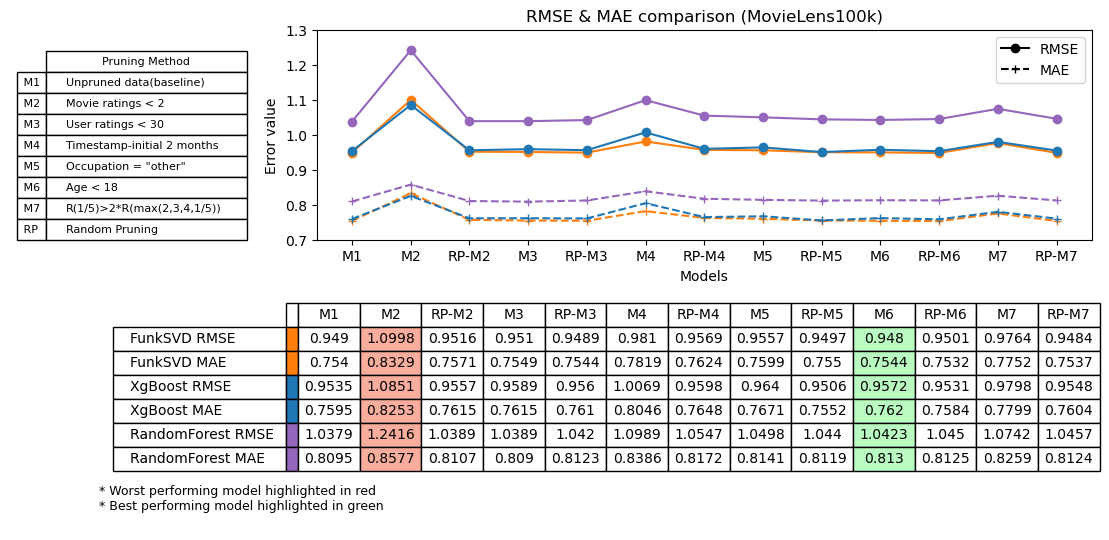

In [1689]:
def visualization_results(svdrmse_m1,svdrmse_m2,svdrmse_rp_m2, svdrmse_m3, svdrmse_rp_m3, svdrmse_m4, svdrmse_rp_m4, svdrmse_m5, svdrmse_rp_m5,svdrmse_m6,svdrmse_rp_m6, svdrmse_m7,svdrmse_rp_m7,
svdmae_m1,svdmae_m2,svdmae_rp_m2, svdmae_m3, svdmae_rp_m3, svdmae_m4, svdmae_rp_m4, svdmae_m5, svdmae_rp_m5,svdmae_m6,svdmae_rp_m6,svdmae_m7,svdmae_rp_m7,
xbrmse_m1,xbrmse_m2,xbrmse_rp_m2, xbrmse_m3, xbrmse_rp_m3, xbrmse_m4,xbrmse_rp_m4, xbrmse_m5,xbrmse_rp_m5,xbrmse_m6,xbrmse_rp_m6,xbrmse_m7,xbrmse_rp_m7,
xbmae_m1,xbmae_m2, xbmae_rp_m2, xbmae_m3, xbmae_rp_m3, xbmae_m4, xbmae_rp_m4, xbmae_m5,xbmae_rp_m5,xbmae_m6,xbmae_rp_m6,xbmae_m7,xbmae_rp_m7,
rfrmse_m1,rfrmse_m2,rfrmse_rp_m2, rfrmse_m3, rfrmse_rp_m3, rfrmse_m4, rfrmse_rp_m4, rfrmse_m5,rfrmse_rp_m5, rfrmse_m6,rfrmse_rp_m6,rfrmse_m7,rfrmse_rp_m7,
rfmae_m1,rfmae_m2,rfmae_rp_m2, rfmae_m3, rfmae_rp_m3, rfmae_m4,rfmae_rp_m4, rfmae_m5,rf_rp_m5,rfmae_m6,rfmae_rp_m6,rfmae_m7,rfmae_rp_m7):
    
    x1 = np.array(['M1','M2', 'RP-M2', 'M3', 'RP-M3', 'M4', 'RP-M4','M5','RP-M5','M6','RP-M6','M7','RP-M7'])
    y1 = np.array([svdrmse_m1,svdrmse_m2,svdrmse_rp_m2, svdrmse_m3, svdrmse_rp_m3, svdrmse_m4, svdrmse_rp_m4, svdrmse_m5, svdrmse_rp_m5,svdrmse_m6,svdrmse_rp_m6,svdrmse_m7,svdrmse_rp_m7])

    y2 = np.array([svdmae_m1,svdmae_m2,svdmae_rp_m2, svdmae_m3, svdmae_rp_m3, svdmae_m4, svdmae_rp_m4, svdmae_m5, svdmae_rp_m5,svdmae_m6,svdmae_rp_m6,svdmae_m7,svdmae_rp_m7])

    y3 = np.array([xbrmse_m1,xbrmse_m2,xbrmse_rp_m2, xbrmse_m3, xbrmse_rp_m3, xbrmse_m4,xbrmse_rp_m4, xbrmse_m5,xbrmse_rp_m5,xbrmse_m6,xbrmse_rp_m6,xbrmse_m7,xbrmse_rp_m7])

    y4 = np.array([xbmae_m1,xbmae_m2, xbmae_rp_m2, xbmae_m3, xbmae_rp_m3, xbmae_m4, xbmae_rp_m4, xbmae_m5,xbmae_rp_m5,xbmae_m6,xbmae_rp_m6,xbmae_m7,xbmae_rp_m7])

    y5 = np.array([rfrmse_m1,rfrmse_m2,rfrmse_rp_m2, rfrmse_m3, rfrmse_rp_m3, rfrmse_m4, rfrmse_rp_m4, rfrmse_m5,rfrmse_rp_m5 ,rfrmse_m6,rfrmse_rp_m6,rfrmse_m7,rfrmse_rp_m7])

    y6 = np.array([rfmae_m1,rfmae_m2,rfmae_rp_m2, rfmae_m3, rfmae_rp_m3, rfmae_m4,rfmae_rp_m4, rfmae_m5,rf_rp_m5,rfmae_m6,rfmae_rp_m6,rfmae_m7,rfmae_rp_m7])

    # Plot 1
    plt.figure(figsize=(10,6))
    plt.subplot(2,1,1)
    plt.plot(x1, y1, 'o-', label = 'RMSE', color = '#ff7f0e')
    plt.yticks([0.7,0.8,0.9,1.0,1.1,1.2,1.3])
    plt.title('RMSE & MAE comparison (MovieLens100k)')
    plt.ylabel('Error value')
    plt.xlabel('Models')

    #Plot 2
    plt.subplot(2,1,1)
    plt.plot(x1, y2, '+--', label = 'MAE', color = '#ff7f0e')
    plt.yticks([0.7,0.8,0.9,1.0,1.1,1.2,1.3])

    # Plot 3
    plt.subplot(2,1,1)
    plt.plot(x1, y3, 'o-', color = '#1f77b4')
    plt.yticks([0.7,0.8,0.9,1.0,1.1,1.2,1.3])

    # Plot 4
    plt.subplot(2,1,1)
    plt.plot(x1, y4, '+--', color = '#1f77b4')
    plt.yticks([0.7,0.8,0.9,1.0,1.1,1.2,1.3])

    # Plot 5
    plt.subplot(2,1,1)
    plt.plot(x1, y5, 'o-', color = '#9467bd')
    plt.yticks([0.7,0.8,0.9,1.0,1.1,1.2,1.3])

    # Plot 6
    plt.subplot(2,1,1)
    plt.plot(x1, y6, '+--', color = '#9467bd')
    plt.yticks([0.7,0.8,0.9,1.0,1.1,1.2,1.3])

    col_labels=['', 'M1', 'M2', 'RP-M2', 'M3', 'RP-M3', 'M4', 'RP-M4', 'M5','RP-M5','M6','RP-M6','M7','RP-M7']
    row_labels=['FunkSVD RMSE','FunkSVD MAE', 'XgBoost RMSE','XgBoost MAE', 'RandomForest RMSE', 'RandomForest MAE']
    colors_key_rp = [["#ff7f0e","w","#f8ad9d","w","w","w","w","w","w","w","#b9fbc0","w","w","w"],["#ff7f0e","w","#f8ad9d","w","w","w","w","w","w","w","#b9fbc0","w","w","w"],
    ["#1f77b4", "w","#f8ad9d","w","w","w","w","w","w","w","#b9fbc0","w","w","w"],["#1f77b4", "w","#f8ad9d","w","w","w","w","w","w","w","#b9fbc0","w","w","w"],
    ["#9467bd", "w","#f8ad9d","w","w","w","w","w","w","w","#b9fbc0","w","w","w"],["#9467bd", "w","#f8ad9d","w","w","w","w","w","w","w","#b9fbc0","w","w","w"]]
    table_vals= [['',svdrmse_m1,svdrmse_m2,svdrmse_rp_m2, svdrmse_m3, svdrmse_rp_m3, svdrmse_m4, svdrmse_rp_m4, svdrmse_m5,svdrmse_m6,svdrmse_rp_m6, svdrmse_rp_m5,svdrmse_m7,svdrmse_rp_m7],
    ['',svdmae_m1,svdmae_m2,svdmae_rp_m2, svdmae_m3, svdmae_rp_m3, svdmae_m4, svdmae_rp_m4, svdmae_m5, svdmae_rp_m5,svdmae_m6,svdmae_rp_m6,svdmae_m7,svdmae_rp_m7],
    ['',xbrmse_m1,xbrmse_m2,xbrmse_rp_m2, xbrmse_m3, xbrmse_rp_m3, xbrmse_m4,xbrmse_rp_m4, xbrmse_m5,xbrmse_rp_m5,xbrmse_m6,xbrmse_rp_m6,xbrmse_m7,xbrmse_rp_m7],
    ['',xbmae_m1,xbmae_m2, xbmae_rp_m2, xbmae_m3, xbmae_rp_m3, xbmae_m4, xbmae_rp_m4, xbmae_m5,xbmae_rp_m5,xbmae_m6,xbmae_rp_m6,xbmae_m7,xbmae_rp_m7],
    ['',rfrmse_m1,rfrmse_m2,rfrmse_rp_m2, rfrmse_m3, rfrmse_rp_m3, rfrmse_m4, rfrmse_rp_m4, rfrmse_m5,rfrmse_rp_m5,rfrmse_m6,rfrmse_rp_m6,rfrmse_m7,rfrmse_rp_m7],
    ['',rfmae_m1,rfmae_m2,rfmae_rp_m2, rfmae_m3, rfmae_rp_m3, rfmae_m4,rfmae_rp_m4, rfmae_m5,rf_rp_m5,rfmae_m6,rfmae_rp_m6,rfmae_m7,rfmae_rp_m7]]

    #The first coordinate is a shift on the x-axis, second coordinate is a gap between plot and text box (table in your case), 
    # third coordinate is a width of the text box, fourth coordinate is a height of text box.

    the_table = plt.table(cellText=table_vals,
         cellColours=colors_key_rp,
         rowLabels=row_labels,
         colWidths = [0.07,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35],
         colLabels=col_labels,
         cellLoc='center',
         fontsize = 30,
         loc='bottom', bbox=[-0.04, -1.1, 1.05, 0.8])

    col_labels_model=['Pruning Method']
    row_labels_model=[' M1 ', ' M2 ', ' M3 ', ' M4 ', ' M5 ',' M6 ', ' M7 ',' RP ']
    model_vals = [['Unpruned data(baseline)'], ['Movie ratings < 2'], ['User ratings < 30'], ['Timestamp-initial 2 months'], ['Occupation = "other"'],['Age < 18'], ['R(1/5)>2*R(max(2,3,4,1/5))'],['Random Pruning']]

    model_table = plt.table(cellText=model_vals,
        colLabels= col_labels_model,
          rowLabels=row_labels_model,
          cellLoc = 'left',
          loc='left', bbox=[-0.35, 0, 0.26, 0.9])

    row_labels_key=["", "", ""]
    colors_key = [["#ff7f0e","w"],["#1f77b4", "w"],["#9467bd", "w"]]
    key_vals = [['','FunkSVD'], ['','XgBoost'], ['','RandomForest']]

    plt.annotate('* Worst performing model highlighted in red \n * Best performing model highlighted in green', 
            xy=(-0.1, 0), 
            xycoords=('axes fraction', 'figure fraction'),
            xytext=(0, 20),  
            textcoords='offset points',
            size=9, ha='center', va='bottom')
    
    legend_elements = [Line2D([0], [0], color='black', linestyle='-', marker='o'), Line2D([0], [0], color='black', linestyle='--', marker='+')]
    plt.legend(legend_elements,['RMSE','MAE'])
    plt.show()

visualization_results(svd_rmse_m1,svd_rmse_m2,svd_rmse_rp_m2,svd_rmse_m3,svd_rmse_rp_m3, svd_rmse_m4 ,svd_rmse_rp_m4, svd_rmse_m5,svd_rmse_rp_m5,svd_rmse_m6,svd_rmse_rp_m6,svd_rmse_m7,svd_rmse_rp_m7,
svd_mae_m1,svd_mae_m2,svd_mae_rp_m2,svd_mae_m3,svd_mae_rp_m3 ,svd_mae_m4, svd_mae_rp_m4,svd_mae_m5, svd_mae_rp_m5,svd_mae_m6, svd_mae_rp_m6, svd_mae_m7,svd_mae_rp_m7,
xb_rmse_m1,xb_rmse_m2,xb_rmse_rp_m2,xb_rmse_m3,xb_rmse_rp_m3, xb_rmse_m4 ,xb_rmse_rp_m4, xb_rmse_m5,xb_rmse_rp_m5,xb_rmse_m6,xb_rmse_rp_m6,xb_rmse_m7,xb_rmse_rp_m7,
xb_mae_m1,xb_mae_m2,xb_mae_rp_m2,xb_mae_m3,xb_mae_rp_m3, xb_mae_m4 ,xb_mae_rp_m4,xb_mae_m5,xb_mae_rp_m5,xb_mae_m6,xb_mae_rp_m6, xb_mae_m7,xb_mae_rp_m7,
rf_rmse_m1,rf_rmse_m2,rf_rmse_rp_m2,rf_rmse_m3, rf_rmse_rp_m3, rf_rmse_m4 ,rf_rmse_rp_m4, rf_rmse_m5, rf_rmse_rp_m5,rf_rmse_m6, rf_rmse_rp_m6,rf_rmse_m7,rf_rmse_rp_m7,
rf_mae_m1,rf_mae_m2,rf_mae_rp_m2,rf_mae_m3, rf_mae_rp_m3 ,rf_mae_m4, rf_mae_rp_m4,rf_mae_m5, rf_mae_rp_m5,rf_mae_m6, rf_mae_rp_m6,rf_mae_m7,rf_mae_rp_m7,)

### Visualisation showing data complexity and time efficiency

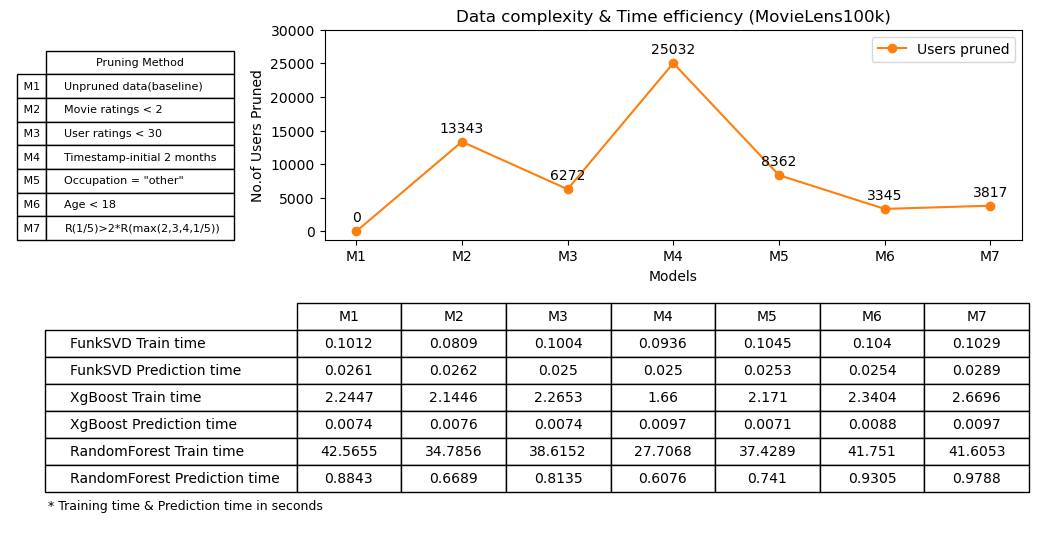

In [1688]:
def visualization_data_time(n2, n3, n4, n5, n6, n7, tt1, tt2, tt3, tt4, tt5, tt6, tt7, tt8, tt9, tt10, tt11, tt12, tt13, tt14, tt15, tt16, tt17, tt18, 
tt19, tt20, tt21, pt1, pt2, pt3, pt4, pt5, pt6, pt7, pt8, pt9, pt10, pt11, pt12, pt13, pt14, pt15, pt16, pt17, pt18, pt19, pt20, pt21):
    
    x1 = np.array(['M1', 'M2', 'M3', 'M4', 'M5', 'M6','M7'])

    n1 = 0

    y1 = np.array([n1, n2, n3, n4, n5, n6, n7])

    y2 = np.array([tt1, tt2, tt3, tt4, tt5, tt6, tt7])

    y3 = np.array([pt1, pt2, pt3, pt4, pt5, pt6, pt7])

    y4 = np.array([tt8, tt9, tt10, tt11, tt12, tt13, tt14])

    y5 = np.array([pt8, pt9, pt10, pt11, pt12, pt13, pt14])

    y6 = np.array([tt15, tt16, tt17, tt18, tt19, tt20, tt21])

    y7 = np.array([pt15, pt16, pt17, pt18, pt19, pt20, pt21])

    # Plot 1
    plt.figure(figsize=(9,6))
    plt.subplot(2,1,1)
    plt.plot(x1, y1, 'o-', label = 'Users pruned', color = '#ff7f0e')
    plt.title('Data complexity & Time efficiency (MovieLens100k)')
    plt.yticks([0,5000,10000,15000,20000,25000,30000])
    plt.ylabel('No.of Users Pruned')
    plt.xlabel('Models')

    col_labels_model=['Pruning Method']
    row_labels_model=[' M1 ', ' M2 ', ' M3 ', ' M4 ', ' M5 ',' M6 ', ' M7 ']
    model_vals = [['Unpruned data(baseline)'], ['Movie ratings < 2'], ['User ratings < 30'], ['Timestamp-initial 2 months'], ['Occupation = "other"'],['Age < 18'], ['R(1/5)>2*R(max(2,3,4,1/5))']]

    model_table = plt.table(cellText=model_vals,
          rowLabels=row_labels_model,
          colLabels=col_labels_model,
          cellLoc = 'left',
          loc='left', bbox=[-0.40, 0, 0.27, 0.9])

    for x,y in zip(x1,y1):
        label = y
        plt.annotate(label,
                 (x,y),
                 textcoords="offset points", 
                 xytext=(0,7),
                 ha='center')

    col_labels=['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7']
    row_labels=['FunkSVD Train time','FunkSVD Prediction time', 'XgBoost Train time','XgBoost Prediction time', 'RandomForest Train time', 'RandomForest Prediction time']
    table_vals= [[tt1, tt2, tt3, tt4, tt5, tt6, tt7],[pt1, pt2, pt3, pt4, pt5, pt6, pt7],
    [tt8, tt9, tt10, tt11, tt12, tt13, tt14],[pt8, pt9, pt10, pt11, pt12, pt13, pt14],
    [tt15, tt16, tt17, tt18, tt19, tt20, tt21],[pt15, pt16, pt17, pt18, pt19, pt20, pt21]]

    the_table = plt.table(cellText=table_vals,
          rowLabels=row_labels,
          colLabels=col_labels,
          cellLoc='center',
          fontsize = 30,
          loc='bottom', bbox=[-0.04, -1.2, 1.05, 0.9])

    plt.annotate('* Training time & Prediction time in seconds', 
            xy=(-0.20, 0), 
            xycoords=('axes fraction', 'figure fraction'),
            xytext=(0, 20),  
            textcoords='offset points',
            size=9, ha='center', va='bottom')
    
    plt.legend(loc = "upper right")
    plt.show()

visualization_data_time(n_m2, n_m3, n_m4, n_m5, n_m6, n_m7, tt_svd_m1, tt_svd_m2, tt_svd_m3, tt_svd_m4, tt_svd_m5, tt_svd_m6, tt_svd_m7, tt_xb_m1,
tt_xb_m2, tt_xb_m3, tt_xb_m4, tt_xb_m5, tt_xb_m6, tt_xb_m7, tt_rf_m1, tt_rf_m2, tt_rf_m3, tt_rf_m4, tt_rf_m5, tt_rf_m6, tt_rf_m7, pt_svd_m1, 
pt_svd_m2, pt_svd_m3, pt_svd_m4, pt_svd_m5, pt_svd_m6, pt_svd_m7, pt_xb_m1, pt_xb_m2, pt_xb_m3, pt_xb_m4, pt_xb_m5, pt_xb_m6, 
pt_xb_m7, pt_rf_m1, pt_rf_m2, pt_rf_m3, pt_rf_m4, pt_rf_m5, pt_rf_m6, pt_rf_m7 )

### Visualisation of RMSE & MAE of all models

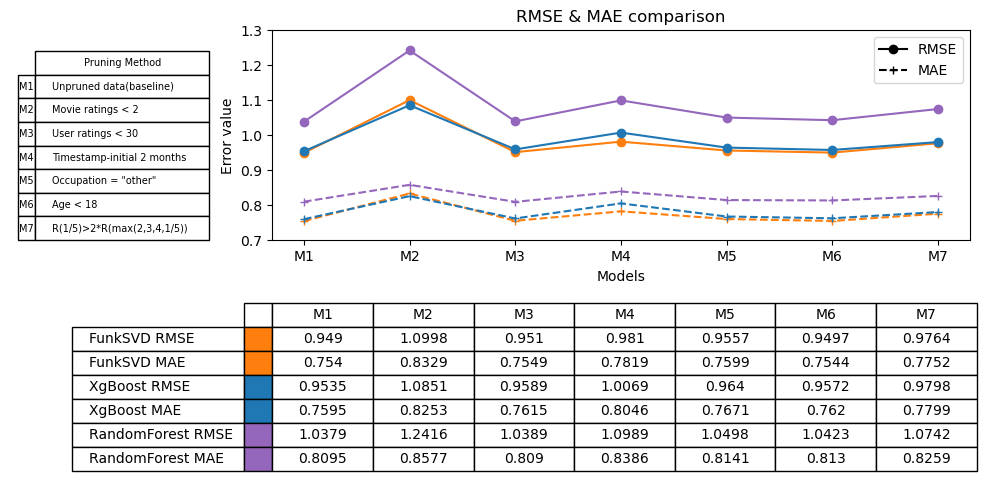

In [1687]:
def visualization_models(rmse_error,rmse_error1, rmse_error2, rmse_error3, rmse_error4, rmse_error5, rmse_m7, mae_error, mae_error1, 
mae_error2, mae_error3, mae_error4, mae_error5, mae_m7, rmse_error6,rmse_error7, rmse_error8, rmse_error9, rmse_error10, rmse_error11, rmse_m7_1, mae_error6, mae_error7, 
mae_error8, mae_error9, mae_error10, mae_error11, mae_m7_1, rmse_error12,rmse_error13, rmse_error14, rmse_error15, rmse_error16, rmse_error17, rmse_m7_2,
mae_error12, mae_error13, mae_error14, mae_error15, mae_error16, mae_error17, mae_m7_2):
    
    x1 = np.array(['M1', 'M2', 'M3', 'M4', 'M5', 'M6','M7'])
    y1 = np.array([rmse_error,rmse_error1, rmse_error2, rmse_error3, rmse_error4, rmse_error5, rmse_m7])

    y2 = np.array([mae_error, mae_error1, mae_error2, mae_error3, mae_error4, mae_error5, mae_m7])

    y3 = np.array([rmse_error6,rmse_error7, rmse_error8, rmse_error9, rmse_error10, rmse_error11, rmse_m7_1])

    y4 = np.array([mae_error6, mae_error7, mae_error8, mae_error9, mae_error10, mae_error11, mae_m7_1])

    y5 = np.array([rmse_error12,rmse_error13, rmse_error14, rmse_error15, rmse_error16, rmse_error17, rmse_m7_2])

    y6 = np.array([mae_error12, mae_error13, mae_error14, mae_error15, mae_error16, mae_error17, mae_m7_2])

    # Plot 1
    plt.figure(figsize=(9,6))
    plt.subplot(2,1,1)
    plt.plot(x1, y1, 'o-', label = 'RMSE', color = '#ff7f0e')
    plt.yticks([0.7,0.8,0.9,1.0,1.1,1.2,1.3])
    plt.title('RMSE & MAE comparison')
    plt.ylabel('Error value')
    plt.xlabel('Models')

    #Plot 2
    plt.subplot(2,1,1)
    plt.plot(x1, y2, '+--', label = 'MAE', color = '#ff7f0e')
    plt.yticks([0.7,0.8,0.9,1.0,1.1,1.2,1.3])

    # Plot 3
    plt.subplot(2,1,1)
    plt.plot(x1, y3, 'o-', color = '#1f77b4')
    plt.yticks([0.7,0.8,0.9,1.0,1.1,1.2,1.3])

    # Plot 4
    plt.subplot(2,1,1)
    plt.plot(x1, y4, '+--', color = '#1f77b4')
    plt.yticks([0.7,0.8,0.9,1.0,1.1,1.2,1.3])

    # Plot 5
    plt.subplot(2,1,1)
    plt.plot(x1, y5, 'o-', color = '#9467bd')
    plt.yticks([0.7,0.8,0.9,1.0,1.1,1.2,1.3])

    # Plot 6
    plt.subplot(2,1,1)
    plt.plot(x1, y6, '+--', color = '#9467bd')
    plt.yticks([0.7,0.8,0.9,1.0,1.1,1.2,1.3])

    col_labels=['','M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7']
    row_labels=['FunkSVD RMSE','FunkSVD MAE', 'XgBoost RMSE','XgBoost MAE', 'RandomForest RMSE', 'RandomForest MAE']
    colors_key_ = [["#ff7f0e","w","w","w","w","w","w","w"],["#ff7f0e","w","w","w","w","w","w","w"],["#1f77b4", "w","w","w","w","w","w","w"],["#1f77b4", "w","w","w","w","w","w","w"],
    ["#9467bd", "w","w","w","w","w","w","w"],["#9467bd", "w","w","w","w","w","w","w"]]
    table_vals= [['',rmse_error,rmse_error1, rmse_error2, rmse_error3, rmse_error4, rmse_error5, rmse_m7],['',mae_error, mae_error1, mae_error2, mae_error3, mae_error4, mae_error5, mae_m7],
    ['',rmse_error6,rmse_error7, rmse_error8, rmse_error9, rmse_error10, rmse_error11, rmse_m7_1],['',mae_error6, mae_error7, mae_error8, mae_error9, mae_error10, mae_error11, mae_m7_1],
    ['',rmse_error12,rmse_error13, rmse_error14, rmse_error15, rmse_error16, rmse_error17, rmse_m7_2],['',mae_error12, mae_error13, mae_error14, mae_error15, mae_error16, mae_error17, mae_m7_2]]

    #The first coordinate is a shift on the x-axis, second coordinate is a gap between plot and text box (table in your case), 
    # third coordinate is a width of the text box, fourth coordinate is a height of text box.

    the_table = plt.table(cellText=table_vals,
            cellColours=colors_key_,
          rowLabels=row_labels,
          colWidths = [0.07,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25],
          colLabels=col_labels,
          cellLoc='center',
          fontsize = 30,
          loc='bottom', bbox=[-0.04, -1.1, 1.05, 0.8])

    col_labels_model=['Pruning Method']
    row_labels_model=['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7']
    model_vals = [['Unpruned data(baseline)'], ['Movie ratings < 2'], ['User ratings < 30'], ['Timestamp-initial 2 months'], ['Occupation = "other"'],['Age < 18'], ['R(1/5)>2*R(max(2,3,4,1/5))']]

    model_table = plt.table(cellText=model_vals,
          rowLabels=row_labels_model,
          colLabels=col_labels_model,
          cellLoc = 'left',
          fontsize = 25,
          loc='left', bbox=[-0.34, 0, 0.25, 0.9])

    row_labels_key=["", "", ""]
    colors_key = [["#ff7f0e","w"],["#1f77b4", "w"],["#9467bd", "w"]]
    key_vals = [['','FunkSVD'], ['','XgBoost'], ['','RandomForest']]

    legend_elements = [Line2D([0], [0], color='black', linestyle='-', marker='o'), Line2D([0], [0], color='black', linestyle='--', marker='+')]
    plt.legend(legend_elements,['RMSE','MAE'])
    plt.show()

visualization_models(svd_rmse_m1,svd_rmse_m2,svd_rmse_m3,svd_rmse_m4, svd_rmse_m5 ,svd_rmse_m6, svd_rmse_m7, svd_mae_m1,svd_mae_m2,svd_mae_m3,svd_mae_m4, 
svd_mae_m5 ,svd_mae_m6, svd_mae_m7, xb_rmse_m1,xb_rmse_m2,xb_rmse_m3,xb_rmse_m4, xb_rmse_m5 ,xb_rmse_m6, xb_rmse_m7, xb_mae_m1,xb_mae_m2,xb_mae_m3,xb_mae_m4, 
xb_mae_m5 ,xb_mae_m6, xb_mae_m7, rf_rmse_m1,rf_rmse_m2,rf_rmse_m3, rf_rmse_m4, rf_rmse_m5 ,rf_rmse_m6, rf_rmse_m7, rf_mae_m1,rf_mae_m2,rf_mae_m3,rf_mae_m4, 
rf_mae_m5 ,rf_mae_m6, rf_mae_m7)